### Task 1. Form the following block and calculate its hash.

```
{
    'index': 4,
    'timestamp': 0,
    'previous_hash':'0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3',
    'nonce': 0,
    'author': 'Satoshi',
    'transactions': [
        {
            'sender_address': 'Alice',
            'recipient_address': 'Bob',
            'value': 10,
            'data': 'Hello Bob!',
        },
        {
            'sender_address': 'Bob',
            'recipient_address': 'Alice',
            'value': 5,
            'data': 'Hello Alice!',
        }
    ]
}
```

In [1]:
from blockchain import Transaction, Block

In [2]:
tx1 = Transaction(sender_address="Alice", recipient_address="Bob", value=10, data="Hello Bob!")
tx2 = Transaction(sender_address="Bob", recipient_address="Alice", value=5, data="Hello Alice!")

In [3]:
block = Block(
    index=4,
    transactions=[tx1, tx2],
    author="Satoshi",
    timestamp=0,
    previous_hash="0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3",
    nonce=0,
)

In [4]:
hash_block = block.compute_hash()
print("Task 1: Block hash is:", hash_block)

Task 1: Block hash is: e02f8bf9303b7b42b77e313887564761dd4923104a9a4d399161adf945b6f064


### Task 2. Run PoW algorithm and find the proof of this block (from task1) with difficulty=3.

In [5]:
from blockchain import BlockchainPeer

In [6]:
BlockchainPeer.difficulty = 3

In [7]:
proof = BlockchainPeer.proof_of_work(block)
print("Task 2: Proof of work (difficulty=3):", proof)

Task 2: Proof of work (difficulty=3): 0002e55332ede6e065fdc770f1ba8c026dbfa86b076a4369cf3aa49913629e21


### Task 3.  Init a single peer and mine 2 blocks with the same 2 transactions from the task1. Why hashes for these blocks are not the same?

In [8]:
peer = BlockchainPeer("SinglePeer")

In [9]:
peer.add_new_transaction(tx1)
peer.add_new_transaction(tx2)
peer.mine()
first_block_hash = peer.last_block.hash
print("Task 3: First mined block hash:", first_block_hash)

Task 3: First mined block hash: 00074ad9f7a85c6fb461433b4ff688955b6488a12c923eb96e604e5c8b88c887


In [10]:
peer.add_new_transaction(tx1)
peer.add_new_transaction(tx2)
peer.mine()
second_block_hash = peer.last_block.hash
print("Task 3: Second mined block hash:", second_block_hash)

Task 3: Second mined block hash: 0009fe708dabbe32e4bb9131900ffd4373e971e03be1f8f3ebc2f72b8fe46c6b


Они отличаются тем, что хэш каждого блока зависит от его индекса, `timestamp` и `nonce`.

### Task 4. Mine 100 blocks (in 1 block should be max 5 transactions) with 5 peers. Plot a distribution of mined blocks by each peer. Explain why the distributions look like this? Now turn on a difficulty bomb and make the same

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from blockchain import BlockchainPeer, BlockchainMainnet, Transaction

warnings.filterwarnings("ignore")

C:\Users\emperor\AppData\Local\Temp\ipykernel_11352\2944232828.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [20]:
peers = [BlockchainPeer(f"Peer{i}") for i in range(1, 6)]
mainnet = BlockchainMainnet(peers)

In [23]:
for _ in tqdm(range(100)):
    num_txs = random.randint(1, 5)
    for _ in range(num_txs):
        selected_sender, selected_recipient = random.choices(range(1, 6), k=2)
        transaction = Transaction(f"Peer{selected_sender}", f"Peer{selected_recipient}", value=1)
        
        for peer in peers:
            peer.add_new_transaction(transaction)
            
    mainnet.run_mining()

100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


In [24]:
peer_blocks = {}
for block in mainnet.get_chain()["chain"]:
    if block.author not in peer_blocks:
        peer_blocks[block.author] = 0
        
    peer_blocks[block.author] += 1
    
peer_blocks

{'Satoshi': 1, 'Peer2': 9, 'Peer5': 79, 'Peer4': 6, 'Peer1': 6}

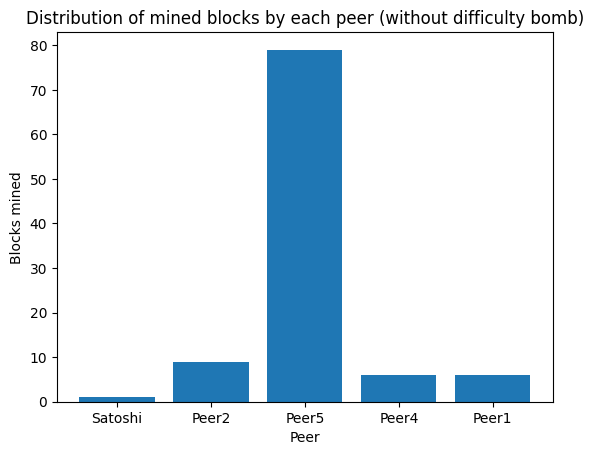

In [25]:
names = list(peer_blocks.keys())
counts = [peer_blocks[name] for name in names]
plt.bar(names, counts)
plt.xlabel("Peer")
plt.ylabel("Blocks mined")
plt.title("Distribution of mined blocks by each peer (without difficulty bomb)")
plt.show()

In [2]:
peers = [BlockchainPeer(f"Peer{i}") for i in range(1, 6)]
mainnet = BlockchainMainnet(peers)

In [3]:
for _ in tqdm(range(100)):
    num_txs = random.randint(1, 5)
    for _ in range(num_txs):
        selected_sender, selected_recipient = random.choices(range(1, 6), k=2)
        transaction = Transaction(f"Peer{selected_sender}", f"Peer{selected_recipient}", value=1)
        
        for peer in peers:
            peer.add_new_transaction(transaction)
            
    mainnet.run_mining(bomb=True)

100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


In [4]:
peer_blocks = {}
for block in mainnet.get_chain()["chain"]:
    if block.author not in peer_blocks:
        peer_blocks[block.author] = 0
        
    peer_blocks[block.author] += 1
    
peer_blocks

{'Satoshi': 1, 'Peer2': 22, 'Peer4': 21, 'Peer1': 19, 'Peer5': 20, 'Peer3': 18}

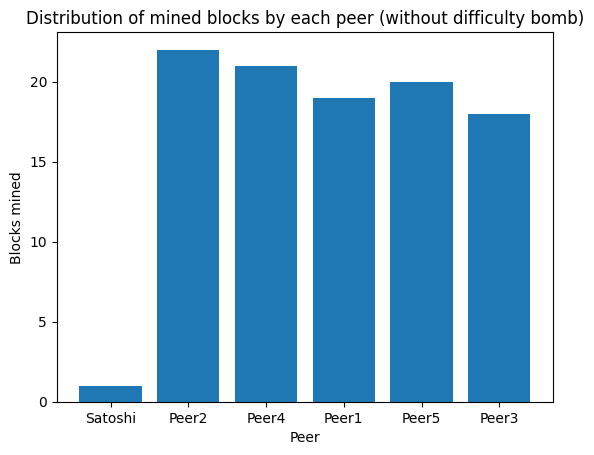

In [5]:
names = list(peer_blocks.keys())
counts = [peer_blocks[name] for name in names]
plt.bar(names, counts)
plt.xlabel("Peer")
plt.ylabel("Blocks mined")
plt.title("Distribution of mined blocks by each peer (with difficulty bomb)")
plt.show()

### Task5. Suppose all blocks have the same timestamp as the genesis block. Mine 5 blocks with transactions from task1 - use the peer name 'Satoshi'. Use the template below to override the updated mine() function with fixed timestamp.

### Find the hash of the block after the block from the task2.

In [12]:
from blockchain import BlockchainPeer, Block
import logging

In [13]:
class FixedTimeBlockchainPeer(BlockchainPeer):
    def mine(self):
        logging.info(f"{self.peer_name} | Start mining (FixedTime)")
        if not self.unconfirmed_transactions:
            logging.info(f"{self.peer_name} | No transactions to mine")
            return
        
        last_block = self.last_block
        new_block = Block(
            index=last_block.index + 1,
            transactions=self.unconfirmed_transactions,
            author=self.peer_name,
            timestamp=0,
            previous_hash=last_block.hash,
            nonce=0,
        )
        
        proof = self.proof_of_work(new_block)
        self._add_block(new_block, proof)
        self.unconfirmed_transactions = []
        self._announce()

In [14]:
peer_fixed = FixedTimeBlockchainPeer("Satoshi")

In [15]:
for i in range(5):
    peer_fixed.add_new_transaction(tx1)
    peer_fixed.add_new_transaction(tx2)
    peer_fixed.mine()

In [17]:
peer_fixed.chain

[{'index': 0, 'author': 'Satoshi', 'transactions': '[]', 'timestamp': 0, 'previous_hash': '0', 'nonce': 2529, 'hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658'},
 {'index': 1, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}, {"data": "Hello Alice!", "recipient_address": "Alice", "sender_address": "Bob", "tx_hash": "27ef2609d6803837823486454e7cb83005bfc8483a1dfdbf6f3651343d00b40c", "value": 5}]', 'timestamp': 0, 'previous_hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658', 'nonce': 9199, 'hash': '0001388e4938037f9c8ef8742d8debbc4200fd9309dbae57e3b081966cbeff65'},
 {'index': 2, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}

Хэш блока после задания 2 `0000b74269d01b5160e499123ffa0e78e0d24ab0b9145cb06fcb4188cc43bdd9`